In [1]:
!cp "/content/drive/MyDrive/FDM Project/03-02-2018.csv" "/content"

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

mpl.rcParams['figure.dpi'] = 300

In [3]:
df = pd.read_csv("03-02-2018.csv", low_memory=False)
df.head()

Dst Port  Protocol            Timestamp  ...  Idle Max  Idle Min   Label
0       443         6  02/03/2018 08:47:38  ...       0.0       0.0  Benign
1     49684         6  02/03/2018 08:47:38  ...       0.0       0.0  Benign
2       443         6  02/03/2018 08:47:40  ...       0.0       0.0  Benign
3       443         6  02/03/2018 08:47:40  ...       0.0       0.0  Benign
4       443         6  02/03/2018 08:47:41  ...       0.0       0.0  Benign

[5 rows x 80 columns]

## EDA

Change values in the target column (Bot -> 1 && Benign -> 0)

In [4]:
df["Label"].replace({"Benign": 0, "Bot": 1}, inplace=True)
df.head()

Dst Port  Protocol            Timestamp  ...  Idle Max  Idle Min  Label
0       443         6  02/03/2018 08:47:38  ...       0.0       0.0      0
1     49684         6  02/03/2018 08:47:38  ...       0.0       0.0      0
2       443         6  02/03/2018 08:47:40  ...       0.0       0.0      0
3       443         6  02/03/2018 08:47:40  ...       0.0       0.0      0
4       443         6  02/03/2018 08:47:41  ...       0.0       0.0      0

[5 rows x 80 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 80 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Dst Port           1048575 non-null  int64  
 1   Protocol           1048575 non-null  int64  
 2   Timestamp          1048575 non-null  object 
 3   Flow Duration      1048575 non-null  int64  
 4   Tot Fwd Pkts       1048575 non-null  int64  
 5   Tot Bwd Pkts       1048575 non-null  int64  
 6   TotLen Fwd Pkts    1048575 non-null  int64  
 7   TotLen Bwd Pkts    1048575 non-null  float64
 8   Fwd Pkt Len Max    1048575 non-null  int64  
 9   Fwd Pkt Len Min    1048575 non-null  int64  
 10  Fwd Pkt Len Mean   1048575 non-null  float64
 11  Fwd Pkt Len Std    1048575 non-null  float64
 12  Bwd Pkt Len Max    1048575 non-null  int64  
 13  Bwd Pkt Len Min    1048575 non-null  int64  
 14  Bwd Pkt Len Mean   1048575 non-null  float64
 15  Bwd Pkt Len Std    1048575 non-n

Drop some columns that have no role in definition of detecting a DDos attack

In [6]:
df.drop(["Protocol", "Dst Port", "Timestamp"], axis=1, inplace=True)

Correlation between each pair of columns

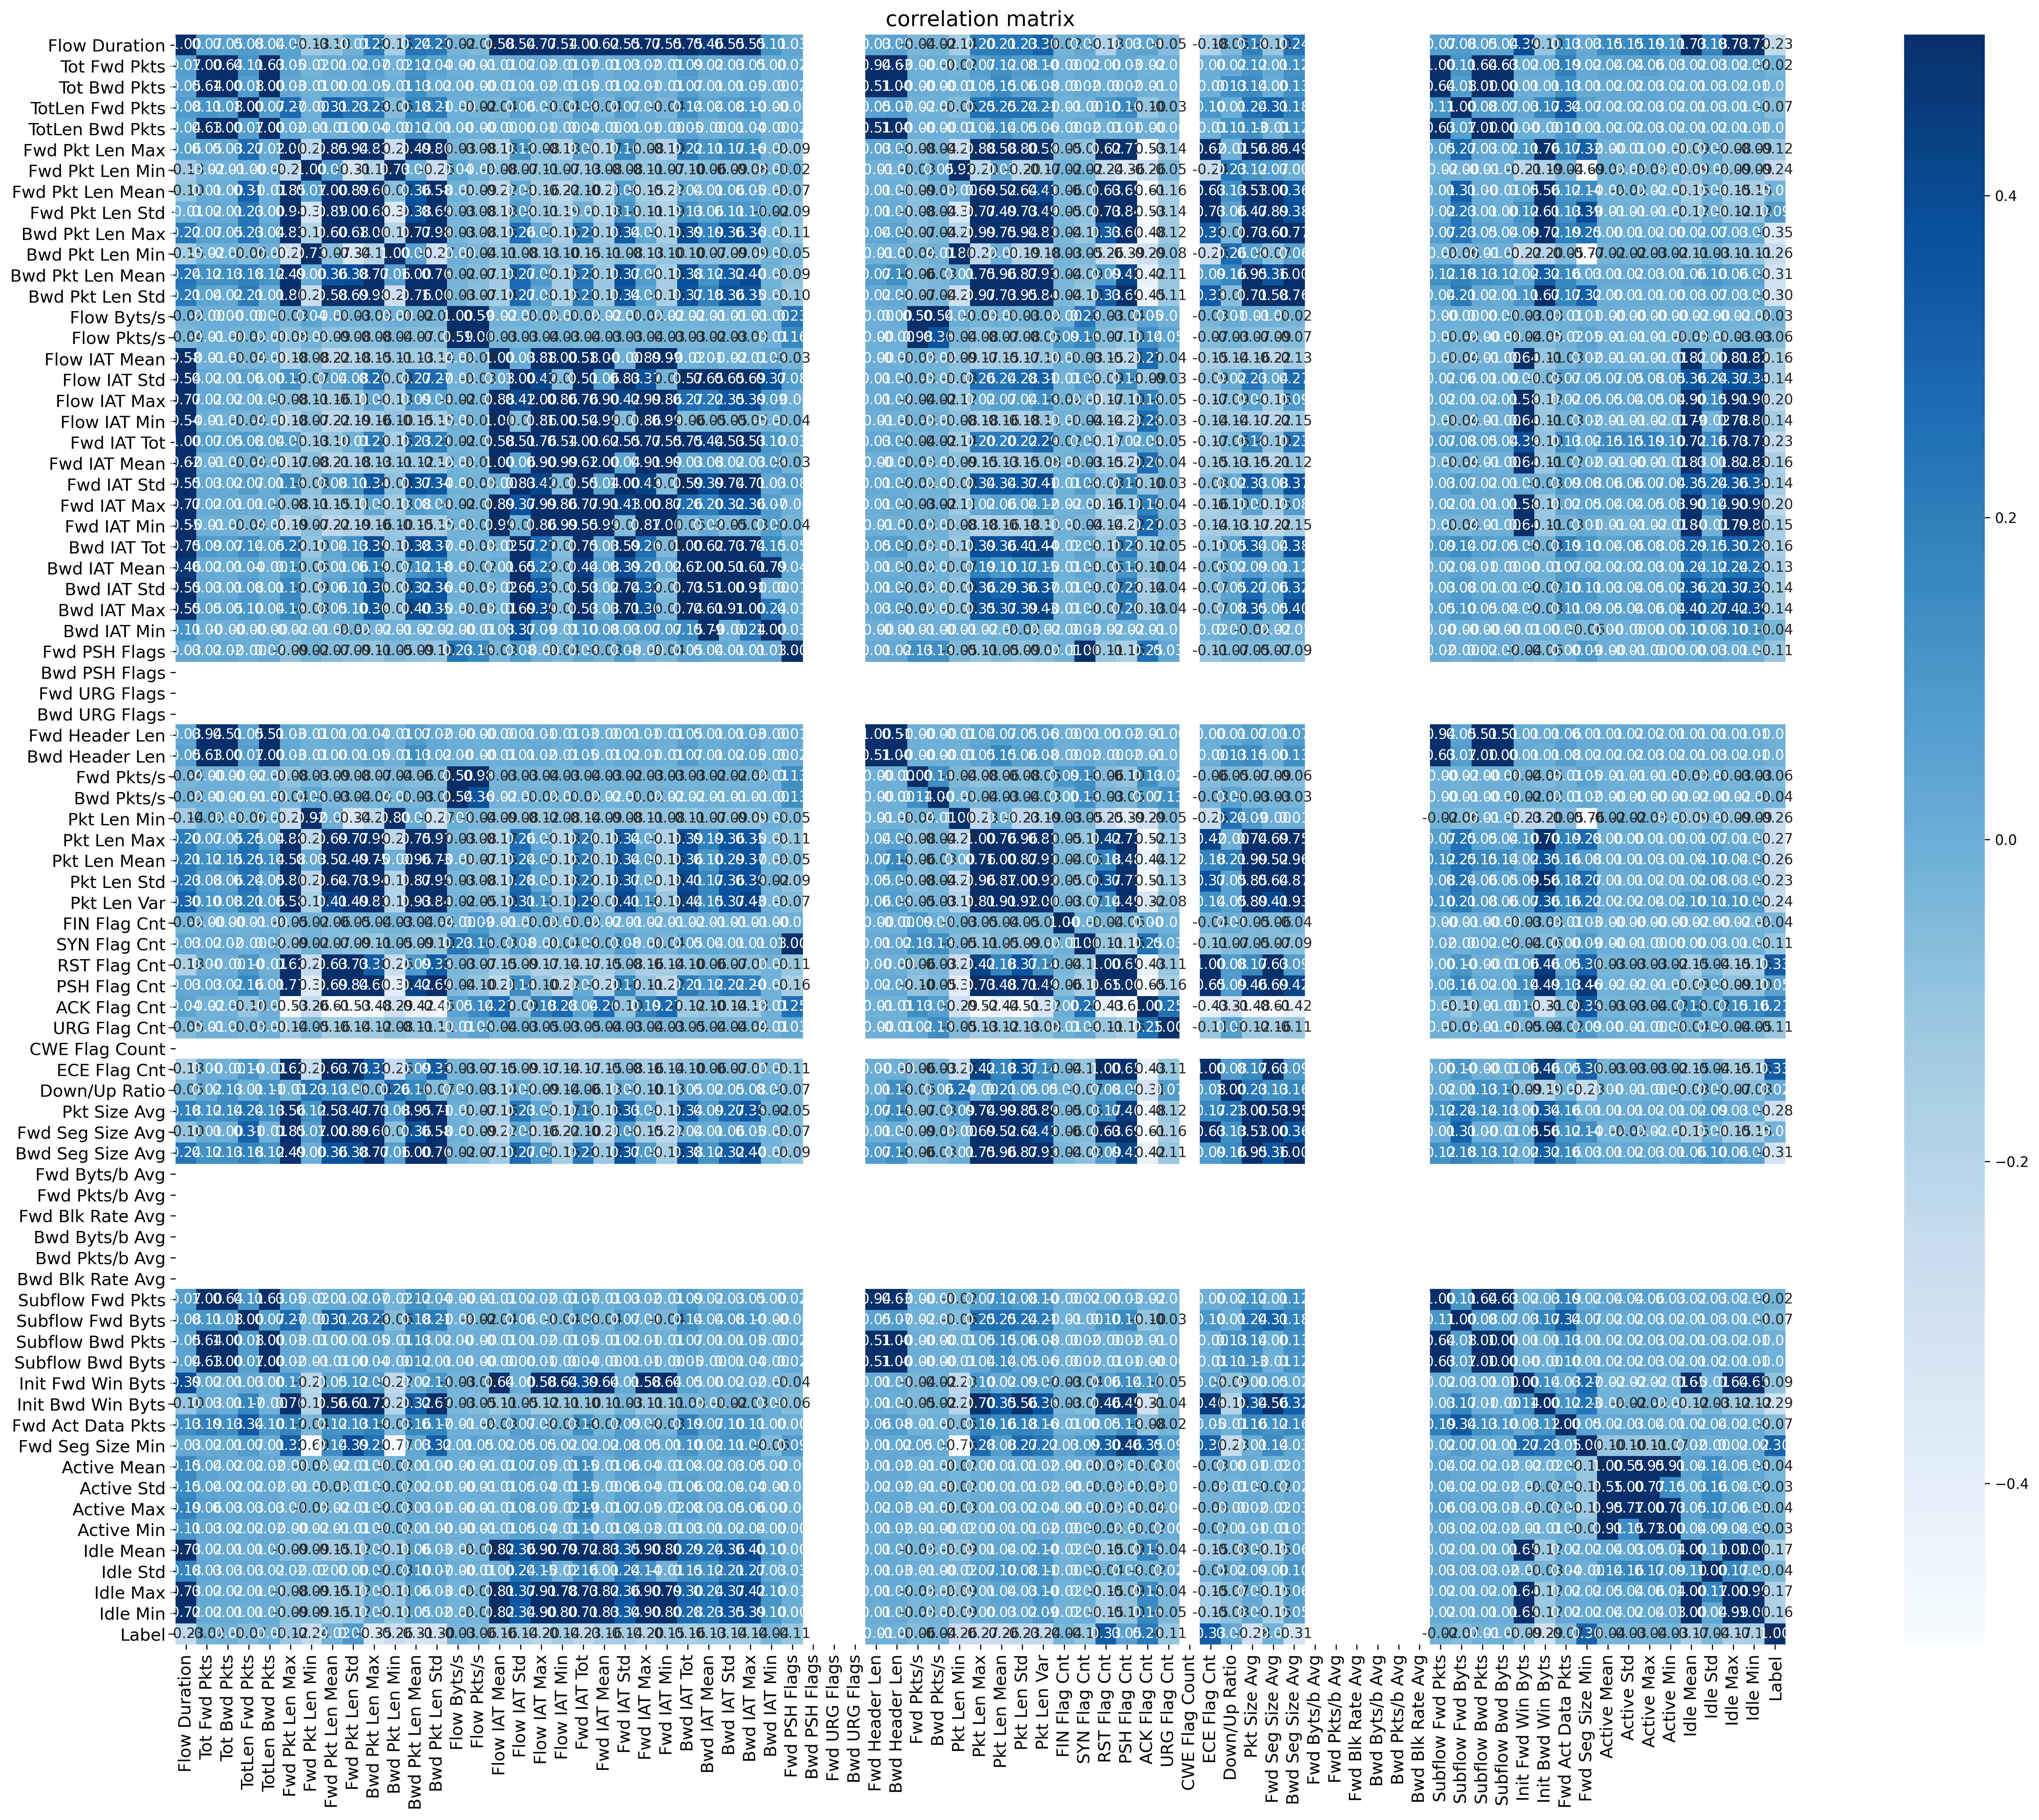

In [7]:
df_corr = df.corr()

fig, ax = plt.subplots(figsize=(24, 18))

hm = sns.heatmap(df_corr, cbar=True, vmin=-0.5, vmax=0.5,
                 fmt='.2f', annot_kws={'size': 10}, annot=True, 
                 square=True, cmap=plt.cm.Blues)

ticks = np.arange(df_corr.shape[0]) + 0.5
ax.set_xticks(ticks)
ax.set_xticklabels(df_corr.columns, rotation=90, fontsize=12)
ax.set_yticks(ticks)
ax.set_yticklabels(df_corr.index, rotation=360, fontsize=12)

ax.set_title('correlation matrix', fontsize=15)
plt.tight_layout()
plt.savefig("heatmap2.png", dpi=500)

Drop columns with high correlation (only one column between two columns)

In [8]:
cor_matrix = df_corr.abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(to_drop)
df = df.drop(to_drop, axis=1)

['TotLen Bwd Pkts', 'Bwd Pkt Len Std', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd Header Len', 'Fwd Pkts/s', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'SYN Flag Cnt', 'ECE Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Idle Max', 'Idle Min']


Removing rows containing infinite value

In [9]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=list(df.columns), inplace=True)
df.head()

Flow Duration  Tot Fwd Pkts  Tot Bwd Pkts  ...  Idle Mean  Idle Std  Label
0         141385             9             7  ...        0.0       0.0      0
1            281             2             1  ...        0.0       0.0      0
2         279824            11            15  ...        0.0       0.0      0
3            132             2             0  ...        0.0       0.0      0
4         274016             9            13  ...        0.0       0.0      0

[5 rows x 54 columns]

In [10]:
print(df.shape)

(1044525, 54)


## Data PreProcessing

Apply min-max-scaling on the data

In [11]:
from sklearn import preprocessing

cols = df.columns
scaler = preprocessing.MinMaxScaler()
scaled_df = scaler.fit_transform(df.values)
df = pd.DataFrame(scaled_df, columns=cols)
df.head()

Flow Duration  Tot Fwd Pkts  Tot Bwd Pkts  ...  Idle Mean  Idle Std  Label
0       0.001178      0.000185      0.000101  ...        0.0       0.0    0.0
1       0.000002      0.000023      0.000014  ...        0.0       0.0    0.0
2       0.002332      0.000232      0.000217  ...        0.0       0.0    0.0
3       0.000001      0.000023      0.000000  ...        0.0       0.0    0.0
4       0.002283      0.000185      0.000188  ...        0.0       0.0    0.0

[5 rows x 54 columns]

Checking diribution of data in target column

In [12]:
df['Label'].value_counts()

0.0    758334
1.0    286191
Name: Label, dtype: int64

In [13]:
X = df.drop(['Label'], axis=1)
y = df['Label']

Splitting data to two sets, train data and test data, with proportion of 0.2

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
y_train.value_counts()

0.0    606607
1.0    229013
Name: Label, dtype: int64

In [16]:
y_test.value_counts()

0.0    151727
1.0     57178
Name: Label, dtype: int64

## Models

Using random forest for classification

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1)

bag.fit(X_train.values, y_train.values.reshape(-1))

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


In [18]:
predictions = bag.predict(X_test.values)

In [19]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test.values.reshape(-1), predictions.reshape(-1)))

[[151681     46]
 [    20  57158]]


In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test.values.reshape(-1), predictions.reshape(-1)))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    151727
         1.0       1.00      1.00      1.00     57178

    accuracy                           1.00    208905
   macro avg       1.00      1.00      1.00    208905
weighted avg       1.00      1.00      1.00    208905



In [21]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(y_test.values.reshape(-1), predictions.reshape(-1), average='binary')

(0.9991958604293406, 0.9996502151177026, 0.9994229861341819, None)